In [1]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import re

mask_dict = {}
npzFiles = glob.glob("/Users/sherryyang/Documents/wiggins-lab/data/0820/xy0/masks/*.png")
for filename in npzFiles:
    img = Image.open(filename)
    img = img.convert('L')
    mask = np.array(img) 

    pattern = r'_t(\d+)'
    match = re.search(pattern, filename)

    if match:
        t_value = match.group(1)
        t_with_prefix = 't' + t_value
    else:
       raise Exception("No match found.")
    
    mask_dict[t_with_prefix] = mask

In [2]:
import cv2
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as pltPolygon

In [3]:
polygons_dict = {}
for key, mask in mask_dict.items():
    frame_dict={}
    for i in range(1,np.max(mask)+1):
        if np.sum(mask == i) > 4:
            cell_mask = mask == i 
            cell_mask = ( cell_mask  * 255).astype(np.uint8)
            contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            polygons = [Polygon(contour.reshape(-1, 2)) for contour in contours]
            frame_dict[str(i)] = polygons[0]
    
    polygons_dict[key]=frame_dict

In [95]:
import itertools
import networkx as nx
G = nx.Graph()

sorted_key = sorted(polygons_dict)

for i in range(len(sorted_key ) - 1):
    t0 = sorted(polygons_dict)[i]
    t1 = sorted(polygons_dict)[i+1]
    cell_dict_t0 = polygons_dict[t0]
    cell_dict_t1 = polygons_dict[t1]
    for cellt0, polygont0 in cell_dict_t0.items():
        for cellt1, polygont1 in cell_dict_t1.items():
            intersection = polygont0.intersection(polygont1)
            union = polygont0.union(polygont1)
            IOU = intersection.area * 1.0 / union.area
            G.add_edge(t0 + "_" + cellt0, t1 + "_" + cellt1,  capacity= IOU)

In [92]:
cell_dict_t1 = polygons_dict['t00001']
for cell in cell_dict_t1:
    G.add_edge('Source', 't00001' + "_" + cell, capacity=1)

In [93]:
cell_dict_final = polygons_dict['t00029']
for cell in cell_dict_final:
    vertex_current = 't00029' + "_" + cell
    G.add_edge('Sink', 't00029' + "_" + cell, capacity=0.01)

In [88]:
flow_value, flow_dict = nx.maximum_flow(G, 'Source', 'Sink')

In [70]:
flow_value

0.2900000000000001

In [89]:
pos = {}

for key, value in polygons_dict.items():
    count = len(value)
    pattern = r't(\d+)'
    match = re.search(pattern, key)
    t_value = int(match.group(1))
    
    start_loc = 0
    for cell_name in value:
        pos[key+'_'+cell_name] = (start_loc, -1 * t_value)
        start_loc += 1.0 / count

pos["Source"] = (0.5, 0)
pos["Sink"] = (0.5, -30)

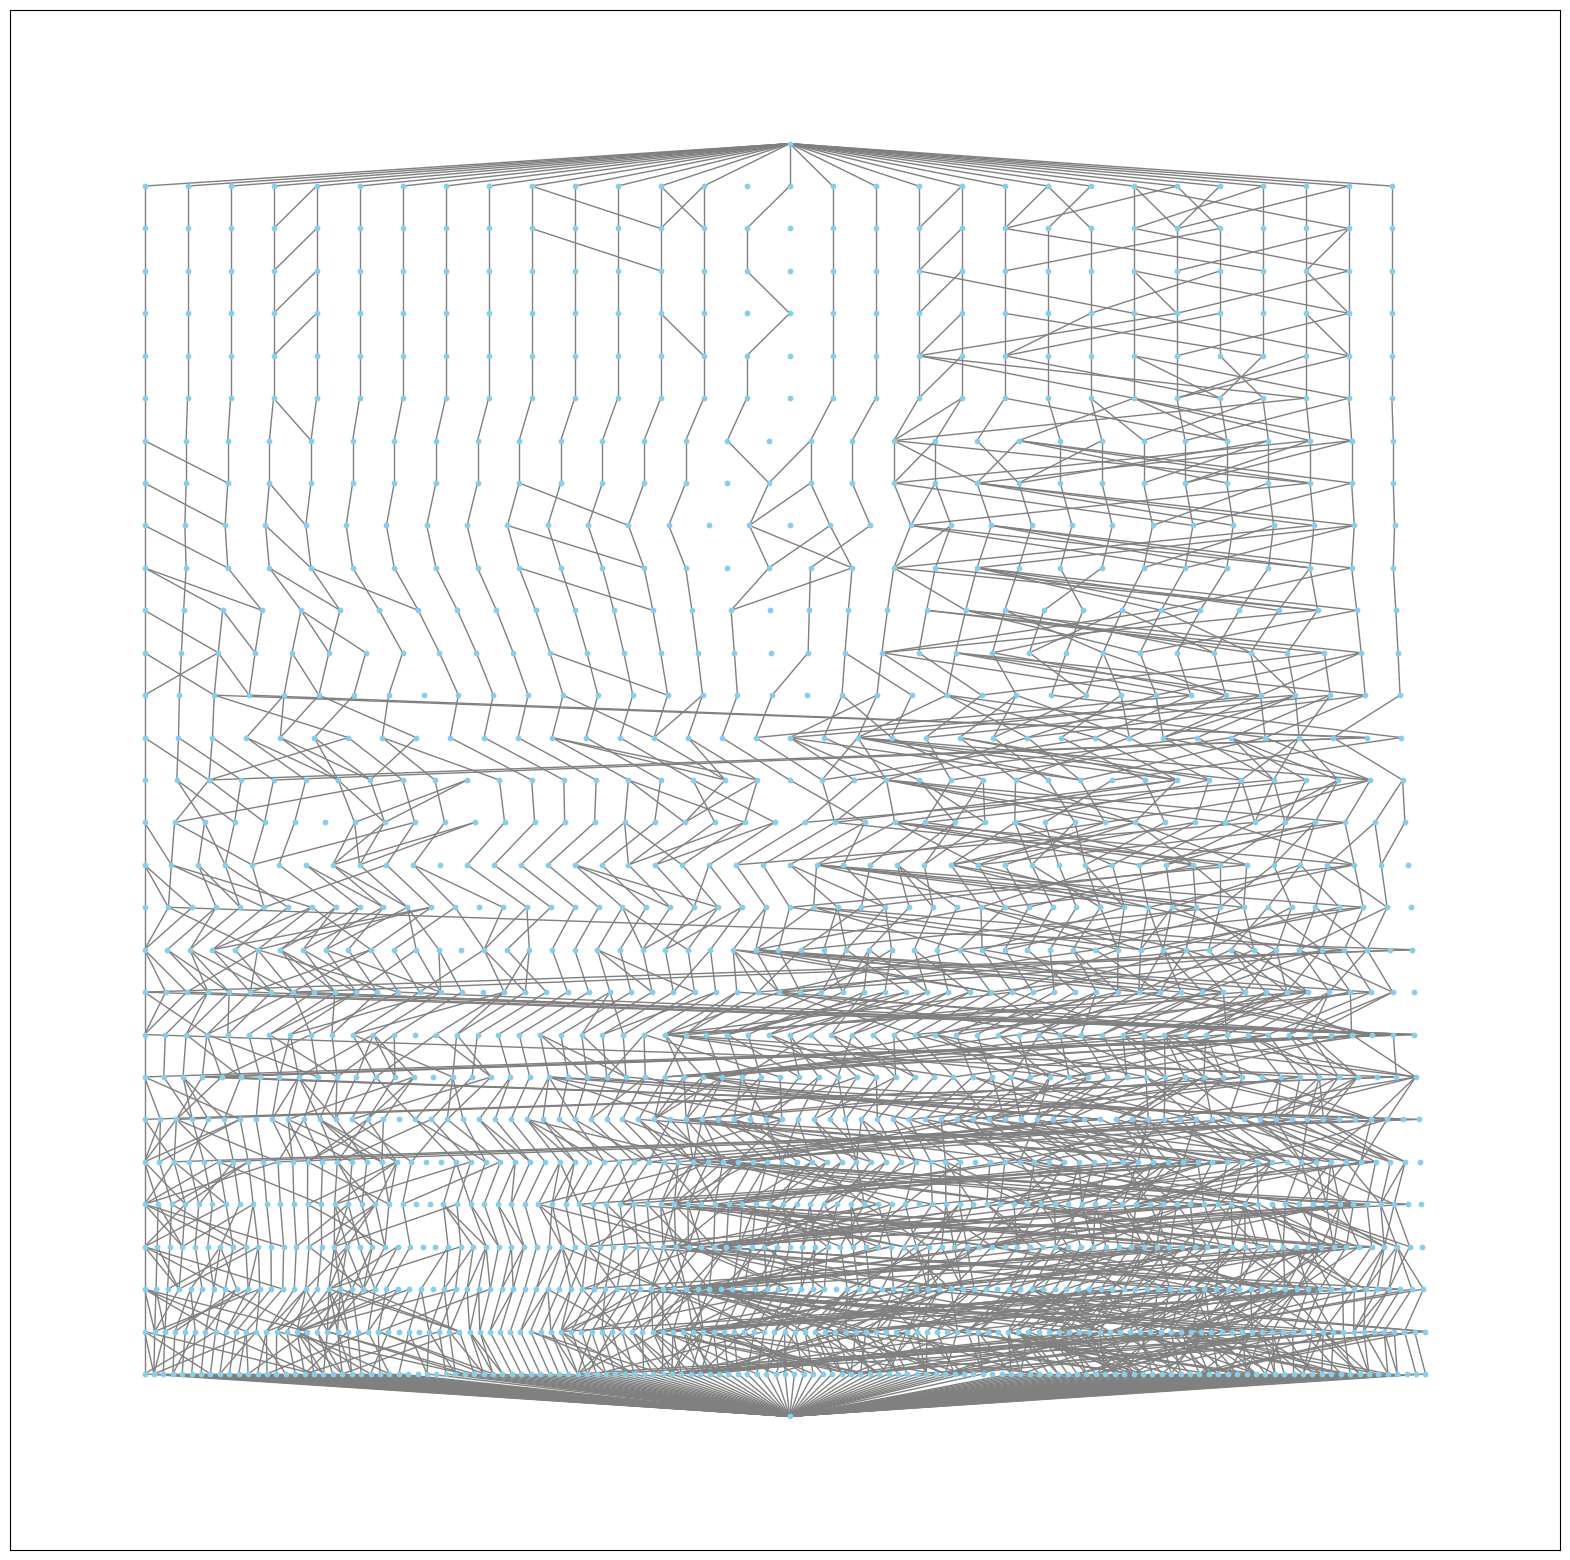

In [94]:
edges_with_flow = [(u, v) for u in flow_dict for v in flow_dict[u] if flow_dict[u][v] > 0]
edge_labels_with_flow = {(u, v): f"{flow_dict[u][v]}" for u, v in edges_with_flow}

plt.figure(figsize=(20, 20))

nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue')
#nx.draw_networkx_labels(G, pos)

# Draw only edges with flow
nx.draw_networkx_edges(G, pos, edgelist=edges_with_flow, edge_color='grey', width=1)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_with_flow)

plt.show()